# **Дипломный проект**

## Постановка задачи

### Уточнение бизнес-постановки задачи

Нужно помочь нашему клиенту повысить прибыль от допродаж в интернет-магазине, целимся в 20 %.

### Выбор технических метрик качества

Precision@3

### Получение данных

## Исследование данных

### Описание структуры данных

**events** — датасет с событиями. Колонки:

* timestamp — время события
* visitorid — идентификатор пользователя
* event — тип события
* itemid — идентификатор объекта
* transactionid — идентификатор транзакции, если она проходила

**category_tree** — файл с деревом категорий (можно восстановить дерево).

* category_id — идентификатор категорий
* parent_id — идентификатор родительской категории

**item_properties** — файл с свойствами товаров.

* timestamp — момент записи значения свойства
* item_id — идентификатор объекта
* property — свойство, кажется, они все, кроме категории, захешированы
* value — значение свойства

### Статистический анализ данных

In [ ]:
!pip install lightfm

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, make_scorer
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from lightfm import LightFM
from lightfm.data import Dataset
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.sparse import coo_matrix

In [ ]:
# 1. Статистический анализ данных

# Загрузка данных
try:
    events = pd.read_csv(r'/content/events.csv')
    category_tree = pd.read_csv(r'/content/category_tree.csv', sep=',')
    item_properties = pd.concat([
        pd.read_csv(r'/content/item_properties_part1.csv'),
        pd.read_csv(r'/content/item_properties_part2.csv')
    ])
except FileNotFoundError as e:
    print(f"Ошибка при загрузке файлов: {e}.  Убедитесь, что файлы 'events.csv', 'category_tree.csv', 'item_properties.csv' находятся в той же директории, что и скрипт.")
    exit()

# Вывод основной информации
print("Events data:")
print(events.head())
print(events.info())

print("\nCategory Tree data:")
print(category_tree.head())
print(category_tree.info())

print("\nItem Properties data:")
print(item_properties.head())
print(item_properties.info())

# Анализ распределения событий
event_counts = events['event'].value_counts()
print("\nEvent type distribution:")
print(event_counts)

# Анализ пропущенных значений
print("\nMissing values in events:")
print(events.isnull().sum())
print("\nMissing values in category_tree:")
print(category_tree.isnull().sum())
print("\nMissing values in item_properties:")
print(item_properties.isnull().sum())

#Обработка данных
events.drop_duplicates(inplace=True)
events.fillna(0, inplace=True)

Events data:
       timestamp  visitorid event    itemid  transactionid
0  1433221332117     257597  view  355908.0            NaN
1  1433224214164     992329  view  248676.0            NaN
2  1433221999827     111016  view  318965.0            NaN
3  1433221955914     483717  view  253185.0            NaN
4  1433221337106     951259  view  367447.0            NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257156 entries, 0 to 1257155
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   timestamp      1257156 non-null  int64  
 1   visitorid      1257156 non-null  int64  
 2   event          1257155 non-null  object 
 3   itemid         1257155 non-null  float64
 4   transactionid  10391 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 48.0+ MB
None

Category Tree data:
   categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0
3        1691 

In [ ]:
# Преобразование timestamp в datetime
events['date'] = pd.to_datetime(events['timestamp'], unit='ms')
item_properties['date'] = pd.to_datetime(item_properties['timestamp'], unit='ms')
events_per_day = events.groupby('date').size()

def preprocess_data(events_df, min_visitor_events=5, min_item_purchases=5):
    # Проверка входных данных
    if not isinstance(events_df, pd.DataFrame):
        print("Error: events_df must be a pandas DataFrame.")
        return None
    if not {'visitorid', 'itemid', 'event', 'transactionid'}.issubset(events_df.columns):
        print("Error: events_df must contain columns 'visitorid', 'itemid', 'event', and 'transactionid'.")
        return None


    # Удаление малоактивных пользователей
    visitor_counts = events_df['visitorid'].value_counts()
    active_visitors = visitor_counts[visitor_counts >= min_visitor_events].index
    events_df = events_df[events_df['visitorid'].isin(active_visitors)]

    # Удаление редко покупаемых товаров (только для событий покупки)
    purchase_events = events_df[events_df['event'] == 'transaction']
    if purchase_events.empty:
        print("Warning: No purchase events found. Skipping item filtering.")
    else:
        item_counts = purchase_events['itemid'].value_counts()
        popular_items = item_counts[item_counts >= min_item_purchases].index
        events_df = events_df[events_df['itemid'].isin(popular_items)]

    return events_df

events = preprocess_data(events, min_visitor_events=5, min_item_purchases=5)

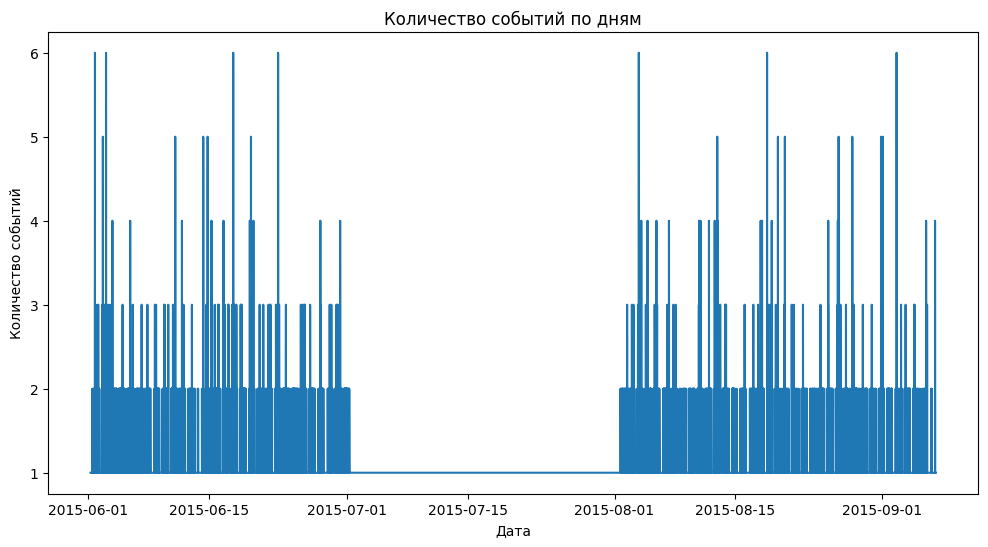

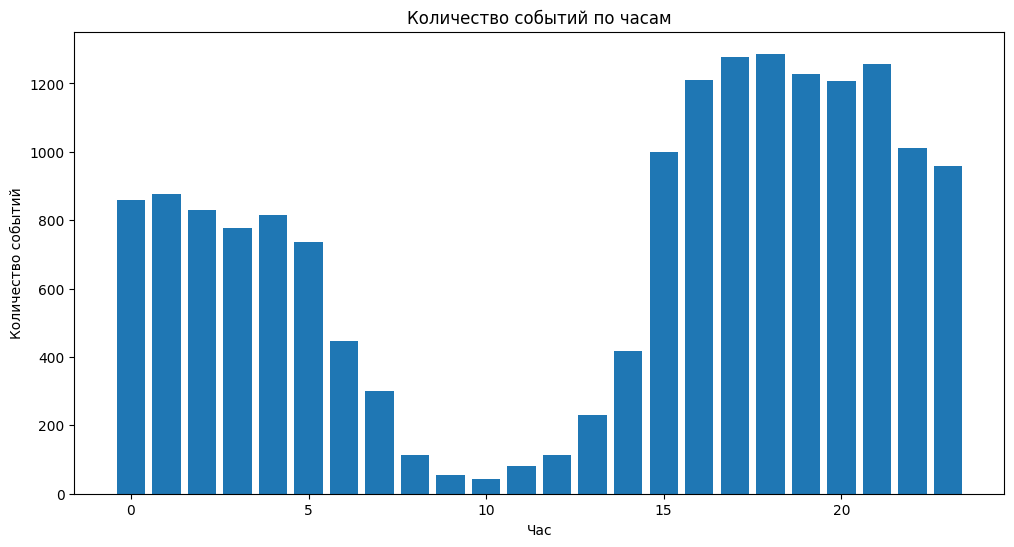

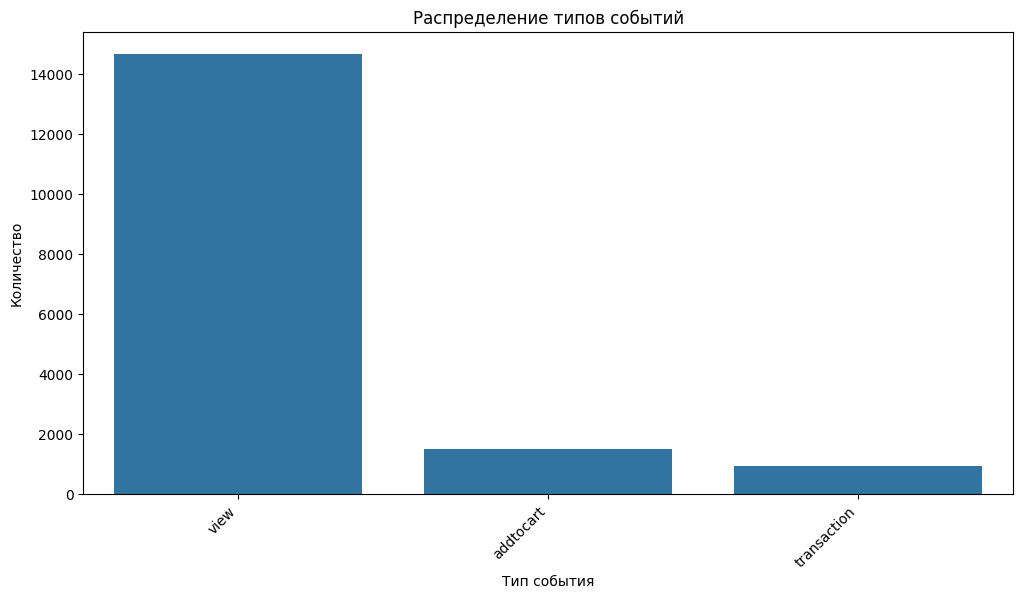

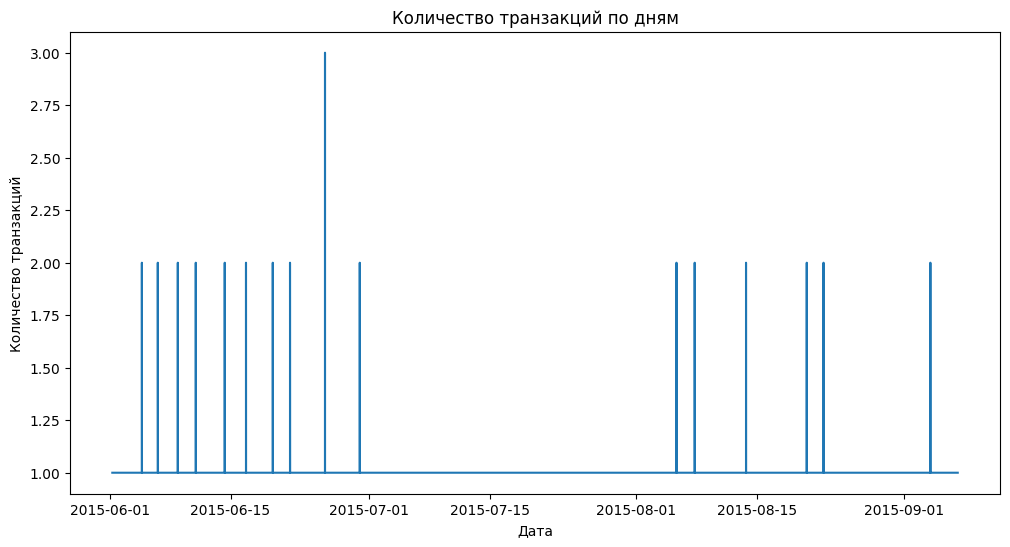

In [ ]:
#EDA
# 1. Анализ событий во времени
plt.figure(figsize=(12, 6))
plt.plot(events_per_day)
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.title("Количество событий по дням")
plt.show()

events_per_hour = events.groupby(events['date'].dt.hour).size()
plt.figure(figsize=(12, 6))
plt.bar(events_per_hour.index, events_per_hour.values)
plt.xlabel("Час")
plt.ylabel("Количество событий")
plt.title("Количество событий по часам")
plt.show()

# 2. Распределение типов событий
event_distribution = events['event'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=event_distribution.index, y=event_distribution.values)
plt.xlabel("Тип события")
plt.ylabel("Количество")
plt.title("Распределение типов событий")
plt.xticks(rotation=45, ha='right')
plt.show()

# 3. Анализ транзакций (предполагаем, что транзакции имеют transactionid != NaN)
transactions = events[events['transactionid'].notna()]
transactions_per_day = transactions.groupby('date').size()
plt.figure(figsize=(12,6))
plt.plot(transactions_per_day)
plt.xlabel("Дата")
plt.ylabel("Количество транзакций")
plt.title("Количество транзакций по дням")
plt.show()

## Создание факторов для модели

### Генерация факторов, связанных с айтемами

In [ ]:
# 2. Генерация факторов, связанных с айтемами

# Количество событий для каждого айтема
item_event_counts = events['itemid'].value_counts().reset_index()
item_event_counts.columns = ['itemid', 'event_count']

# Количество покупок для каждого айтема
item_purchase_counts = events[events['event'] == 'transaction']['itemid'].value_counts().reset_index()
item_purchase_counts.columns = ['itemid', 'purchase_count']

# Объединение факторов
item_factors = pd.merge(item_event_counts, item_purchase_counts, on='itemid', how='left').fillna(0)
item_factors['purchase_ratio'] = item_factors['purchase_count'] / item_factors['event_count']

print("\nItem factors:")
print(item_factors.head())

# Добавление категорий айтемам (если это возможно на основе item_properties)
# Пример: Наиболее часто встречающаяся категория для каждого itemid
item_categories = item_properties[item_properties['property'] == 'categoryid'][['itemid', 'value']]
item_categories = item_categories.groupby('itemid')['value'].agg(lambda x: x.value_counts().index[0]).reset_index()
item_categories.columns = ['itemid', 'categoryid'] # Переименование для соответствия
item_factors = pd.merge(item_factors, item_categories, on='itemid', how='left')


Item factors:
     itemid  event_count  purchase_count  purchase_ratio
0  461686.0          794              54        0.068010
1  257040.0          477              12        0.025157
2  119736.0          451              53        0.117517
3    9877.0          444              13        0.029279
4  320130.0          377              13        0.034483


### Генерация факторов айтем-юзер

In [ ]:
# 3. Генерация факторов айтем-юзер

# Количество взаимодействий пользователя с айтемом (все типы событий)
user_item_interactions = events.groupby(['visitorid', 'itemid'])['event'].count().reset_index()
user_item_interactions.columns = ['visitorid', 'itemid', 'interaction_count']

# Количество покупок айтема пользователем
user_item_purchases = events[events['event'] == 'transaction'].groupby(['visitorid', 'itemid'])['transactionid'].count().reset_index()
user_item_purchases.columns = ['visitorid', 'itemid', 'purchase_count']

# Объединение факторов
user_item_factors = pd.merge(user_item_interactions, user_item_purchases, on=['visitorid', 'itemid'], how='left').fillna(0)
user_item_factors['purchase_ratio'] = user_item_factors['purchase_count'] / user_item_factors['interaction_count']

print("\nUser-item factors:")
print(user_item_factors.head())

# Добавление информации об айтемах к факторам юзер-айтем
user_item_factors = pd.merge(user_item_factors, item_factors, on='itemid', how='left')


User-item factors:
   visitorid    itemid  interaction_count  purchase_count  purchase_ratio
0        485  148103.0                  1             0.0        0.000000
1        485  248455.0                  1             0.0        0.000000
2       1765  330469.0                  6             1.0        0.166667
3       1786  179601.0                  1             0.0        0.000000
4       1786  290999.0                  1             0.0        0.000000


In [ ]:
# Валидация: разбиение по времени.
def split_data_by_time(events, train_ratio, val_ratio):
    """
    Разделяет данные на тренировочную, валидационную и тестовую выборки по времени.

    Args:
        events: Pandas DataFrame с колонкой 'timestamp', сортированной по времени.
        train_ratio: Доля данных для тренировочной выборки (0 < train_ratio < 1).
        val_ratio: Доля данных для валидационной выборки (0 < val_ratio < 1).

    Returns:
        Кортеж из трех Pandas DataFrames: train_data, val_data, test_data.
        Возвращает None, если входные данные некорректны.
    """

    if not isinstance(events, pd.DataFrame):
        print("Ошибка: events должен быть Pandas DataFrame.")
        return None
    if 'timestamp' not in events.columns:
        print("Ошибка: events должен содержать колонку 'timestamp'.")
        return None
    if not all(isinstance(x, (int, float)) for x in [train_ratio, val_ratio]):
        print("Ошибка: train_ratio и val_ratio должны быть числами.")
        return None
    if not (0 < train_ratio < 1 and 0 < val_ratio < 1):
        print("Ошибка: train_ratio и val_ratio должны быть в интервале (0, 1).")
        return None
    if train_ratio + val_ratio >= 1:
        print("Ошибка: train_ratio + val_ratio должно быть меньше 1.")
        return None


    events = events.sort_values('timestamp')
    n = len(events)
    train_size = int(n * train_ratio)
    val_size = int(n * val_ratio)

    train_data = events[:train_size]
    val_data = events[train_size:train_size + val_size]
    test_data = events[train_size + val_size:]

    return train_data, val_data, test_data


train_data, val_data, test_data = split_data_by_time(events, 0.6, 0.2)

print("Тренировочные данные:\n", train_data)
print("\nВалидационные данные:\n", val_data)
print("\nТестовые данные:\n", test_data)

events = events.sort_values(by=['timestamp'])

def validate_time_split(events, train_df, val_df, test_df):
    """Валидация разбиения данных по времени."""

    # Проверяем, что данные отсортированы по времени
    if not events['date'].is_monotonic_increasing:
        raise ValueError("Данные в events не отсортированы по времени.")

    # Проверяем монотонность временных меток в каждом подмножестве
    for df, name in [(train_df, "тренировочной"), (val_df, "валидационной"), (test_df, "тестовой")]:
        if not df['date'].is_monotonic_increasing:
            raise ValueError(f"Данные в {name} выборке не отсортированы по времени.")

    # Проверяем, что временные метки в подмножествах не пересекаются
    if train_df['timestamp'].max() >= val_df['timestamp'].min():
        raise ValueError("Временные метки тренировочной и валидационной выборок пересекаются.")
    if val_df['timestamp'].max() >= test_df['timestamp'].min():
        raise ValueError("Временные метки валидационной и тестовой выборок пересекаются.")

train_ratio = 0.6
val_ratio = 0.2

train_df, val_df, test_df = split_data_by_time(events, train_ratio, val_ratio)

validate_time_split(events, train_df, val_df, test_df)
print("Валидация разбиения по времени прошла успешно.")

Тренировочные данные:
             timestamp  visitorid      event    itemid  transactionid  \
17516   1433143014718     563755       view  389814.0            0.0   
5072    1433143078326     563755  addtocart  389814.0            0.0   
21406   1433144059695     563755       view  389814.0            0.0   
2763    1433144087531     563755       view  389814.0            0.0   
9642    1433144498600     563755       view  389814.0            0.0   
...               ...        ...        ...       ...            ...   
731864  1438984593747     995025  addtocart     546.0            0.0   
738696  1438984634014    1106118       view  266900.0            0.0   
726511  1438984756485    1106118       view  266900.0            0.0   
734342  1438984796796    1106118       view  266900.0            0.0   
734381  1438985600573     674163       view  206218.0            0.0   

                          date  
17516  2015-06-01 07:16:54.718  
5072   2015-06-01 07:17:58.326  
21406  2015-0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Фильтруем только свойства товаров
props_filtered = item_properties.query("property != 'category'")

# Агрегируем свойства товаров
item_features = props_filtered.groupby('itemid').first().reset_index()

# Определяем основную категорию для каждого товара
item_categories = category_tree.merge(item_properties.query("property == 'category'"), left_on='categoryid', right_on='value', how='left')

# Объединяем признаки товаров и их категории
item_features_with_cat = item_features.merge(item_categories, on='itemid', how='left')

# Заполняем пустоты нулевыми значениями
item_features_with_cat.fillna(value=0, inplace=True)

# Демонстрируем сформированный набор признаков товаров
print("\nПризнаки товаров с категориями:")
print(item_features_with_cat.head())


Признаки товаров с категориями:
   itemid    timestamp_x property_x                   value_x  \
0     0.0  1433646000000        112                    679677   
1     1.0  1433041200000        296                    866110   
2     2.0  1433646000000        202  648485 n6000.000 n72.000   
3     3.0  1435460400000        159                    519769   
4     4.0  1431831600000  available                         0   

               date_x  categoryid  parentid  timestamp_y  property_y  value_y  \
0 2015-06-07 03:00:00         0.0       0.0          0.0           0        0   
1 2015-05-31 03:00:00         0.0       0.0          0.0           0        0   
2 2015-06-07 03:00:00         0.0       0.0          0.0           0        0   
3 2015-06-28 03:00:00         0.0       0.0          0.0           0        0   
4 2015-05-17 03:00:00         0.0       0.0          0.0           0        0   

   date_y  
0       0  
1       0  
2       0  
3       0  
4       0  


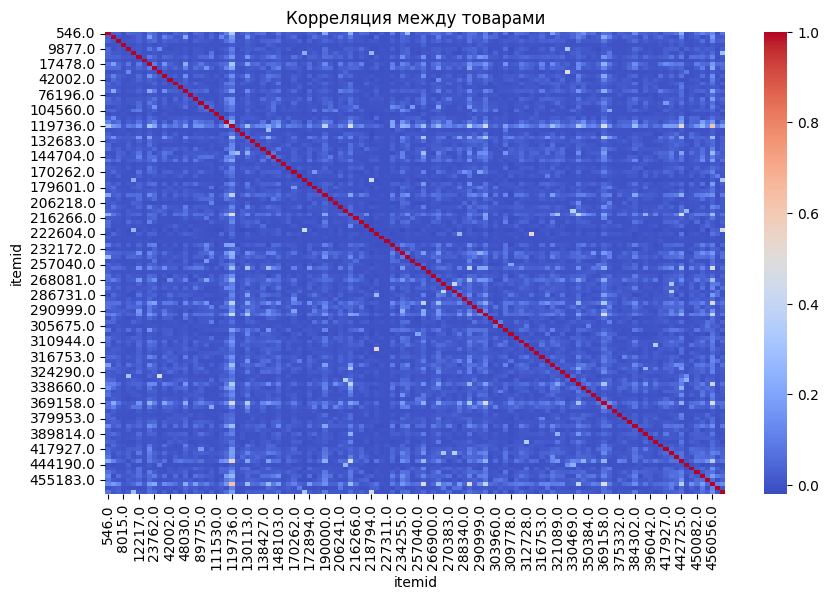

In [ ]:
# Формируем матрицу взаимодействия пользователей и товаров
user_item_matrix = events.pivot_table(values='timestamp', index='visitorid', columns='itemid', aggfunc='count', fill_value=0)

# Ограничиваемся данными о покупках
purchase_matrix = user_item_matrix.loc[user_item_matrix.sum(axis=1) > 0]

# Визуализируем плотность взаимодействия
plt.figure(figsize=(10, 6))
sns.heatmap(purchase_matrix.corr(), cmap='coolwarm')
plt.title('Корреляция между товарами')
plt.show()

## Проведение экспериментов

### Коллаборативная фильтрация


In [ ]:
from sklearn.decomposition import TruncatedSVD

# Применяем SVD для уменьшения размерности
svd = TruncatedSVD(n_components=50)
latent_matrix = svd.fit_transform(purchase_matrix)

# Распечатываем коэффициент объясняемой дисперсии
explained_var_ratio = svd.explained_variance_ratio_.cumsum()[49]
print(f'\nОбъясняемая дисперсия (на основе первых 50 компонентов): {explained_var_ratio * 100:.2f}%')


Объясняемая дисперсия (на основе первых 50 компонентов): 80.95%


### Факторизационные машины

In [ ]:
from scipy.sparse import coo_matrix

# Преобразовываем индекс данных для удобства использования
purchase_matrix_labeled = purchase_matrix.reset_index(drop=True)

# Преобразуем обычную матрицу в разрежённый формат COO
sparse_matrix = coo_matrix(purchase_matrix_labeled.values)

# Создаем объект LightFM
lfm_model = LightFM(loss='warp')

# Тренируем модель на преобразованной матрице
lfm_model.fit(sparse_matrix, epochs=30, num_threads=4)

# Рассчитываем метрики Precision@3
train_precision = precision_at_k(lfm_model, sparse_matrix, k=3).mean()
print(f"\nСредний показатель Precision@3 на обучающей выборке: {train_precision:.4f}")


Средний показатель Precision@3 на обучающей выборке: 0.4179


### XGBoost для задачи классификации

In [ ]:
# Готовим данные для классификации
X = purchase_matrix_labeled.iloc[:, :-1]
y = purchase_matrix_labeled.iloc[:, -1]

# Разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Останавливаемся только на общих классах, представленных в обеих частях
common_classes = np.intersect1d(y_train, y_test)

# Исключаем строки с редкими классами
mask_train = np.isin(y_train, common_classes)
mask_test = np.isin(y_test, common_classes)

X_train_common = X_train[mask_train]
y_train_common = y_train[mask_train]
X_test_common = X_test[mask_test]
y_test_common = y_test[mask_test]

# Повторяем процедуру перекодирования
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_common)
y_test_encoded = label_encoder.transform(y_test_common)

# Обучаем модель на очищенном наборе данных
xgb_model = XGBClassifier()
xgb_model.fit(X_train_common, y_train_encoded)

# Сохраните модель
xgb_model.save_model("xgb_model.json")  # Сохраните в формате JSON

# Полный отчёт по классификации
y_pred = xgb_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       815
           1       0.50      0.06      0.11        17
           2       0.00      0.00      0.00        11
           3       0.10      0.17      0.12         6
           4       0.14      0.25      0.18         4
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          24       0.00      0.00      0.00         1

    accuracy                           0.94       865
   macro avg       0.16      0.13      0.13       865
weighted avg       0.93      0.94      0.93       865

